In [3]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the directory where your results are stored
results_dir = "results"

# A list of the models you want to load results for
# You can add more models to this list as you generate their results
models_to_load = ['bart', 'flan_t5', 't5']

# This dictionary will store the loaded data
all_evaluation_data = {}

print(f"Loading evaluation results from the '{results_dir}' directory...")

for model_name in models_to_load:
    # Construct the filename using a consistent naming convention
    filename = f"{model_name}_evaluation_results.json"
    file_path = os.path.join(results_dir, filename)

    if os.path.exists(file_path):
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                # Load the JSON data into a dictionary
                model_results = json.load(f)
                
                # Convert any numpy types (like from your previous output) to standard floats
                # This makes the data more robust for plotting and processing
                for key, value in model_results.items():
                    if isinstance(value, np.floating):
                        model_results[key] = float(value)
                
                # Store the loaded results in the main dictionary
                all_evaluation_data[model_name] = model_results
                print(f"Successfully loaded results for '{model_name}'.")

        except json.JSONDecodeError:
            print(f"Error: Could not decode JSON from file '{file_path}'. Skipping.")
        except Exception as e:
            print(f"An unexpected error occurred while loading '{file_path}': {e}")
    else:
        print(f"Warning: File not found at '{file_path}'. Skipping '{model_name}'.")

print("\nFinished loading all available results.")
# print("--- Loaded Data ---")
# print(all_evaluation_data)

# You can now convert this data into a DataFrame for visualization
if all_evaluation_data:
    df_results = pd.DataFrame(all_evaluation_data).T
    print("\n--- DataFrame for Visualization ---")
    print(df_results)
else:
    print("\nNo evaluation data was loaded. Please check the file paths and names.")

Loading evaluation results from the 'results' directory...
Successfully loaded results for 'bart'.
Successfully loaded results for 'flan_t5'.
Successfully loaded results for 't5'.

Finished loading all available results.

--- DataFrame for Visualization ---
          rouge1   rouge2   rougeL  rougeLsum     bleu     gleu     wer
bart     95.4669  91.4817  94.4139    94.4140  89.1150  88.0130  9.7321
flan_t5  96.1092  92.4352  95.0939    95.1083  90.3366  89.0457  8.9557
t5       95.9252  92.0622  94.8887    94.8978  89.8838  88.6944  9.0864


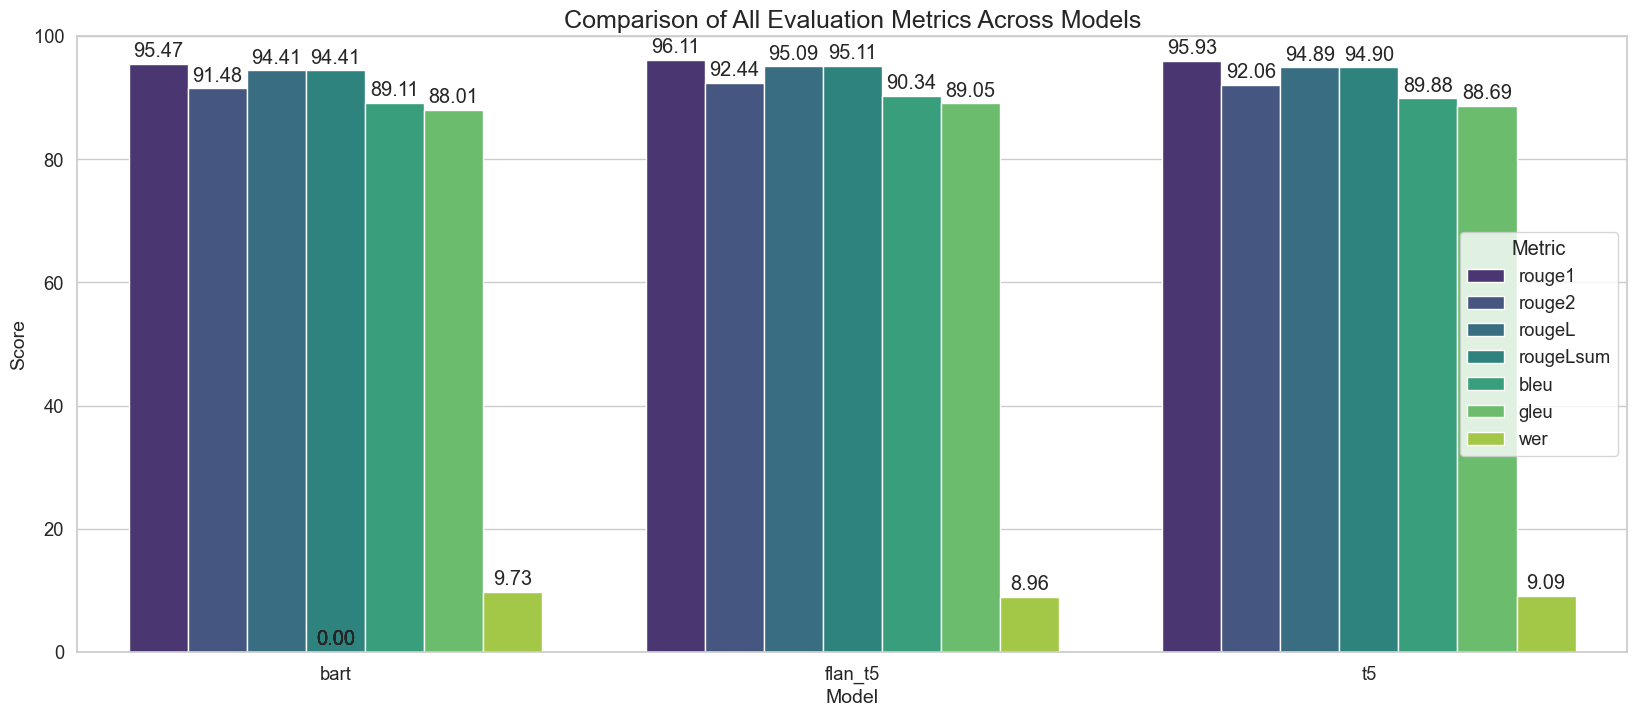

In [9]:
"""This visualization is a great way to directly compare each model's score for every metric side-by-side. 
It makes it easy to see which model has the highest or lowest score for a particular metric."""

# Melt the DataFrame for easier plotting with seaborn
df_plot = df_results.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
df_plot.rename(columns={'index': 'Model'}, inplace=True)

# Set a consistent style for the plots
sns.set_theme(style="whitegrid")
sns.set_context("notebook", font_scale=1.2)

# Create the grouped bar plot
plt.figure(figsize=(20, 8))
ax = sns.barplot(x='Model', y='Score', hue='Metric', data=df_plot, palette="viridis")

# Add a title and labels
plt.title('Comparison of All Evaluation Metrics Across Models', fontsize=18)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim(0, 100)  # Set a more relevant y-axis range from 0 to 100

# Add score values on top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')

plt.legend(title='Metric', loc='center right')
plt.show()


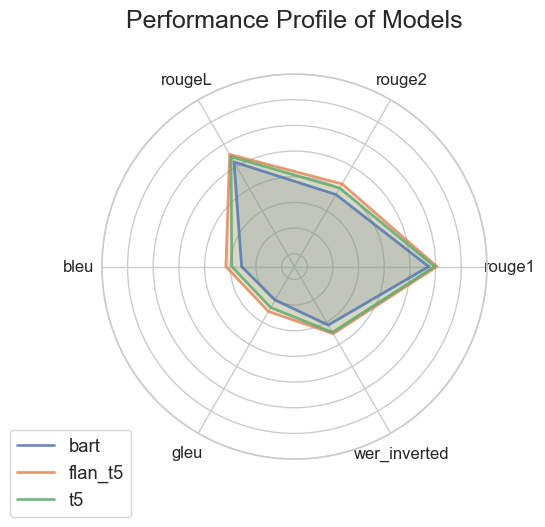

In [7]:
"""A radar chart is an excellent choice for a more holistic comparison. Each axis represents a metric, allowing you to see the overall "shape" of a model's performance.
The larger the polygon, the better the model performs across all metrics. 
For the WER metric, which is an error rate, we will inverse the score so that a higher value on the chart always represents better performance."""

# Prepare data for the radar chart
df_radar = df_results.copy()
# Invert WER score so that a higher value is always better for visualization
df_radar['wer_inverted'] = 100 - df_radar['wer']
df_radar = df_radar.drop(columns=['rougeLsum', 'wer']) # remove rougeLsum for clarity

# Get metrics and models
categories = list(df_radar.columns)
labels = list(df_radar.index)
num_vars = len(categories)

# Create a figure
plt.figure(figsize=(5, 5))
ax = plt.subplot(111, polar=True)

# Set the angle for each axis
angles = [n / float(num_vars) * 2 * np.pi for n in range(num_vars)]
angles += angles[:1]

# Plot each model's results
for i, row in df_radar.iterrows():
    values = row.values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=i, alpha=0.8)
    ax.fill(angles, values, alpha=0.2)

# Set up the axes and labels
plt.xticks(angles[:-1], categories, size=12)
ax.set_yticklabels([]) # Hide radial labels for a cleaner look
ax.set_rlabel_position(0)
ax.set_ylim(85, 100) # Set a consistent y-axis for better comparison

# Add title and legend
plt.title('Performance Profile of Models', size=18, y=1.1)
plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
plt.show()